## Convolutional Template Matcher

This notebook demonstartes the implementation of a 1D convolutional neural net, coded up in pytorch, that takes weights from data driven templates.

This notebook is mainly for demonstarting the implementation. The actually ability of this method to work on real world signals will depend on how
much the audio signals vary, as well as how much background noise is present in the "clean" samples, as well as other factors not enumerated here.


### Load packages

In [389]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math # basic math functions
import io # We use this one for basic file input/output operations
import scipy.fftpack as fftpack # We use this one to perform Fourier transforms
import urllib.request as request  # We use this one to get things from the web
import scipy.signal as sp
import numpy as np
from IPython.display import Audio, display

### Create toy audio samples

In [388]:
framerate = 44100
length = 3
t = np.linspace(0,length,framerate*length)
m = 400
start_f1 = 11000
start_f2 = 5000
data = np.sin(2*np.pi*start_f1*t+3000*np.sin(2*np.pi*3*t))
data1 = np.sin(2*np.pi*start_f2*t+4000*np.sin(2*np.pi*0.5*t))

### Listen to toy audio samples

In [390]:
Audio(data,rate=framerate)

In [129]:
Audio(data1,rate=framerate)

### Plot spectrograms of toy audio and generate FFTs

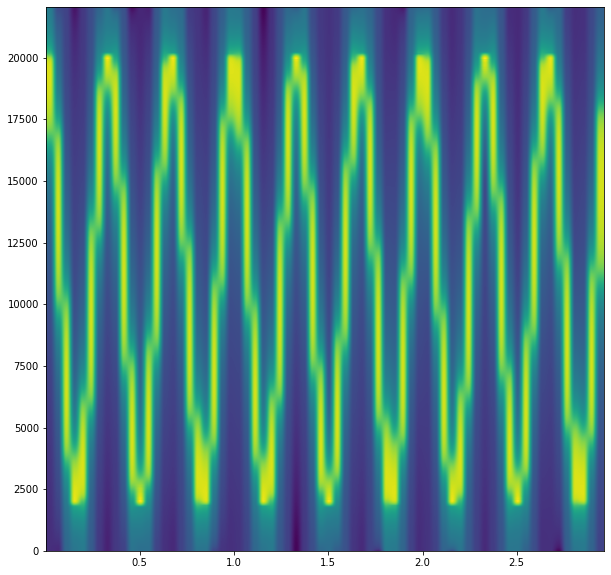

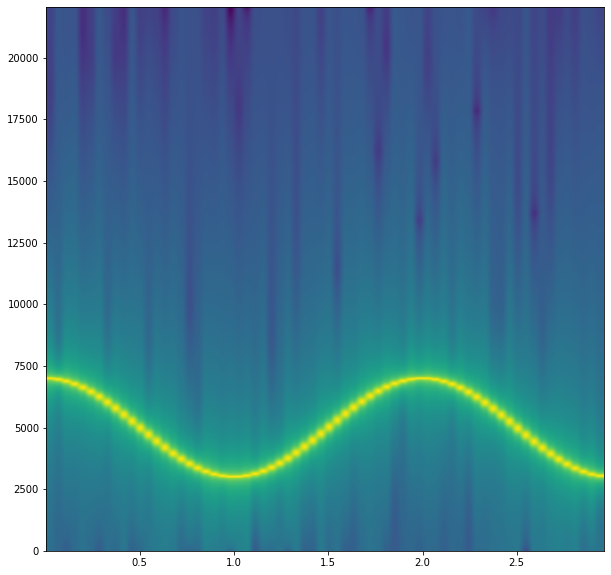

In [391]:
plt.figure(figsize=(10,10))
Sxx1, _, _, _ = plt.specgram(data,Fs=framerate,NFFT=1024*2)
plt.show()

plt.figure(figsize=(10,10))
Sxx2, _, _, _ = plt.specgram(data1,Fs=framerate,NFFT=1024*2)
plt.show()

### Look at shape of FFTs from toy audio

In [152]:
Sxx1.shape, Sxx2.shape

((1025, 68), (1025, 68))

### Create pytorch model for template matching

In [181]:
class template_model(torch.nn.Module):
    '''
    Template Model

    Designed to take data driven templates as weights and convolve
    those weights against test data for pattern matching.

    Inputs:
        in_channels [int]: number of channels for input data (number of FFT bins)
        out_channels [int]: number of templates used for pattern matching
        kernel_size [int]: number of time bins in input data templates
        weights [numpy array]: weights for the templates
        stride [int]: how many samples to move ahead on input data before performation convolution (default: 1)
        padding [int]: how many zeros to add to input data (default: 0)

    '''
    def __init__(self,in_channels,out_channels,kernel_size,weights,stride=1,padding=0) -> None:
        super().__init__()
        self.conv = torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv.weight = torch.nn.Parameter(torch.from_numpy(weights).float())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

### Create templates from audio samples. Mimic missing part of band and concatenate data.

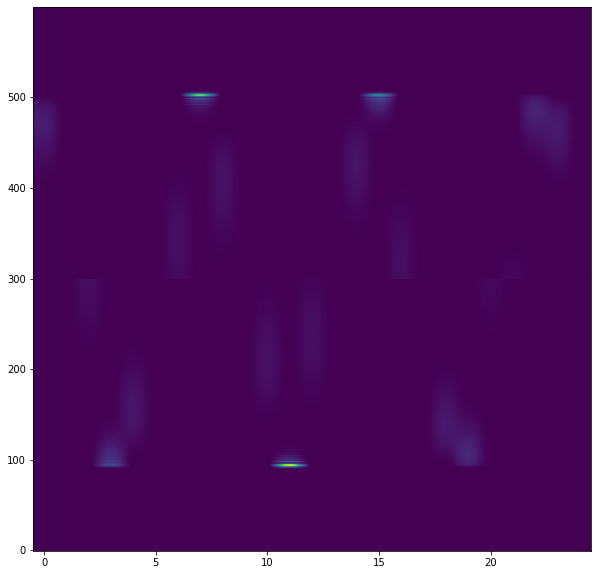

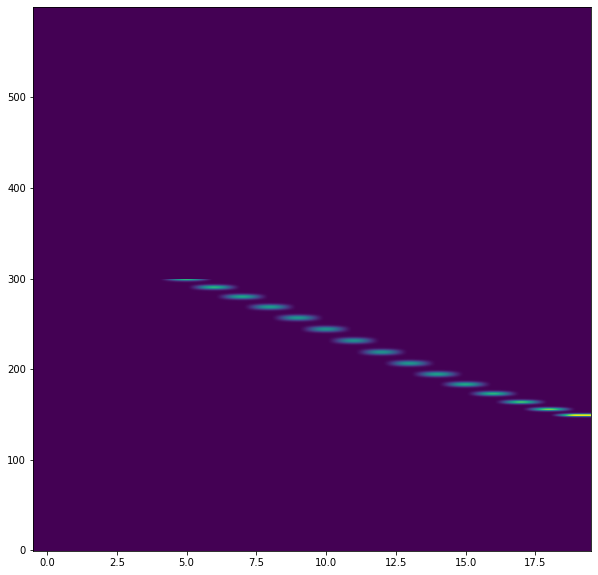

In [173]:
#Only take first 300 and last 300 bins and concatenate in vertical (frequency) axis
template1 = np.vstack((Sxx1[:300,:25],Sxx1[-300:,:25]))
plt.figure(figsize = (10,10))
plt.imshow(template1,aspect="auto",origin='lower')
plt.show()

template2 = np.vstack((Sxx2[:300,:20],Sxx2[-300:,:20]))
plt.figure(figsize = (10,10))
plt.imshow(template2,aspect="auto",origin='lower')
plt.show()

### Create filterbank from list of templates

In [399]:
def create_filterbank(templates):
    '''
    create_filterbank

    filter shape is expected to be NFFT x T (channels, width)

    inputs:
        list of templates: list of numpy arrays
    returns:
        numpy array
    '''
    max_length = max([t.shape[1] for t in templates])
    num_channels = templates[0].shape[0]
    num_templates = len(templates)
    filterbank = np.zeros((num_templates, num_channels, max_length))
    for idx, t in enumerate(templates):
        filterbank[idx,:,:t.shape[1]] = t
    return filterbank


In [401]:
filterbank1 = create_filterbank([template1,template2])
filterbank1.shape

(2, 600, 25)

In [402]:
#BCT... # of batches, # of channels, # of time bins (samples)
#For filterbank, # of batches is number of templates
#For filterbank, # of time bins is max length of any one template (rest will be zero padded)
print(template1.shape, template2.shape)
filterbank = np.zeros((2,600,25))
filterbank[0,:,:template1.shape[1]] = template1
filterbank[1,:,:template2.shape[1]] = template2

(600, 25) (600, 20)


### Create model with filterbank as weights

In [404]:
test_model = template_model(filterbank.shape[1],filterbank.shape[0],filterbank.shape[2],filterbank)

### Create test data

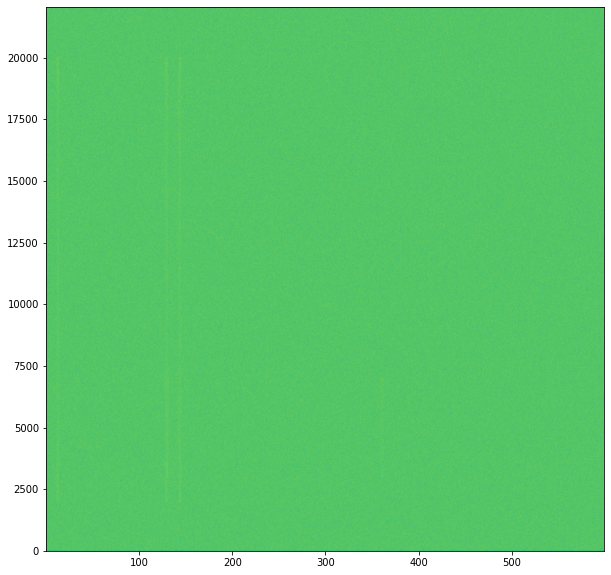

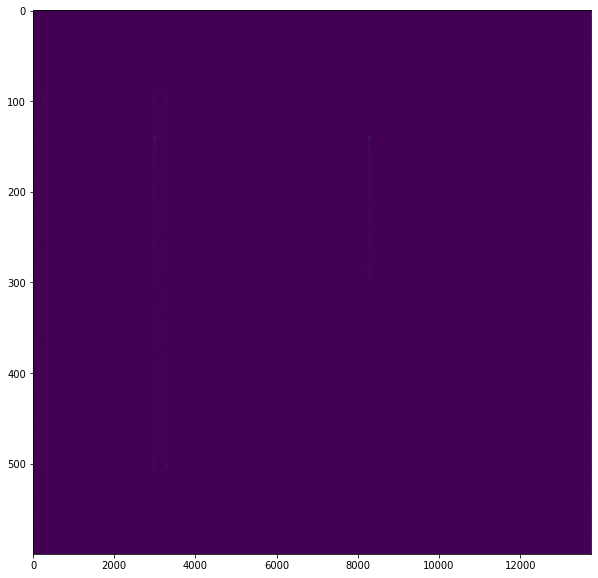

In [352]:
test_data = np.hstack((np.zeros(500000),data,np.zeros(5000000),data,np.zeros(500000),data,np.zeros(20000000)))
test_data_2 = np.hstack((np.zeros(500000),np.zeros(data.shape[0]),np.zeros(5000000),np.zeros(data1.shape[0]//2),data1,np.zeros(10000000),data1))
test_data_2 = np.hstack((test_data_2, np.zeros(test_data.shape[0]-test_data_2.shape[0])))
test_data = test_data + test_data_2
noise = np.random.normal(size=test_data.shape[0])
test_data = test_data + noise
plt.figure(figsize=(10,10))
Sxx_test, _, _, _ = plt.specgram(test_data,Fs=framerate,NFFT=1024*2)
plt.show()
Sxx_test = np.vstack((Sxx_test[:300,:],Sxx_test[-300:,:]))
plt.figure(figsize=(10,10))
plt.imshow(Sxx_test,aspect="auto")
plt.show()

### Reshape test data into signal batch for entry into model

In [353]:
Sxx_test = Sxx_test.reshape(1, Sxx_test.shape[0], Sxx_test.shape[1])

### Run model on data for inference

In [405]:
#TO DO: If running in an inference pipeline, the will be multiple batches that are infered on. 
#The output will need to be timestamp where passing, the value of the zscore, the filter number
# and potentially the band number, if multiple bands
#For now, just output zscore... 
def infer(batch, model, threshold=0):
    '''
    infer 
    
    Think of this as a map/reduce job, running on the GPU. The inputs are data and the templates.
    These are mapped to zscores. The zscores can be reduced by only counting parts of the data
    where the zscore for a given filter is greater than a threshold.

    inputs:
        batch: pytroch array, shape (B,C,T) - (B is batch, C is channel, T is samples)
        model: pytorch model
        threshold: float (default is 0): number of sigmas
    returns:
        zscore: pytorch array
    '''
    output = test_model(batch)
    mean = torch.mean(output,dim=2)
    std = torch.std(output,dim=2)
    zscore = (torch.swapaxes(output,1,2)-mean)/std
    zscore = torch.swapaxes(zscore,1,2)
    zscore = torch.abs(zscore)
    return zscore

In [428]:
#Length of output is length input in last channel - length filterbank in last channel + 1 
#If the data is the same size as the kernel, there would still be one output. 
#This arthimetic will be important later if all the data to be inferenced can't fit on the GPU
# and needs to be processed with a dataloader
batch = torch.from_numpy(Sxx_test).float()
zscore = infer(batch,test_model)
zscore = zscore.data.cpu().numpy()
print(zscore.shape)

(1, 2, 13724)


### Plot zscore versus sample number

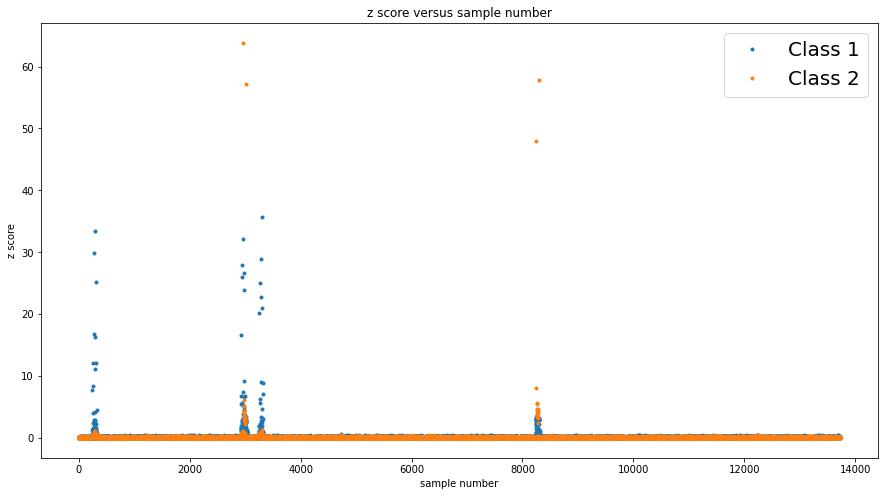

In [429]:
plt.figure(figsize=(15,8))
plt.plot(zscore[0][0],".",label="Class 1")
plt.plot(zscore[0][1],".",label="Class 2")
plt.title("z score versus sample number")
plt.ylabel("z score")
plt.xlabel("sample number")
plt.legend(loc=1,fontsize=20)
plt.show()

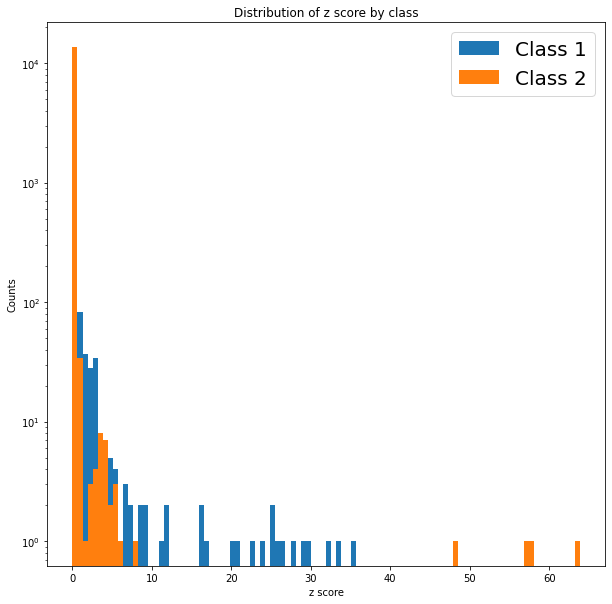

In [430]:
bins = np.histogram(zscore[0].reshape(-1),100)
plt.figure(figsize=(10,10))
plt.hist(zscore[0][0],bins=bins[1],label='Class 1')
plt.hist(zscore[0][1],bins=bins[1],label='Class 2')
plt.legend(loc=1,fontsize=20)
plt.title("Distribution of z score by class")
plt.xlabel("z score")
plt.ylabel("Counts")
plt.yscale('log')
plt.show()

### Now run the model on the GPU

In [423]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

Tesla K80
Tesla K80


### Put model and data on GPU

In [439]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [440]:
test_model = test_model.to(device)
batch = batch.to(device)

In [441]:
zscore = infer(batch, test_model)

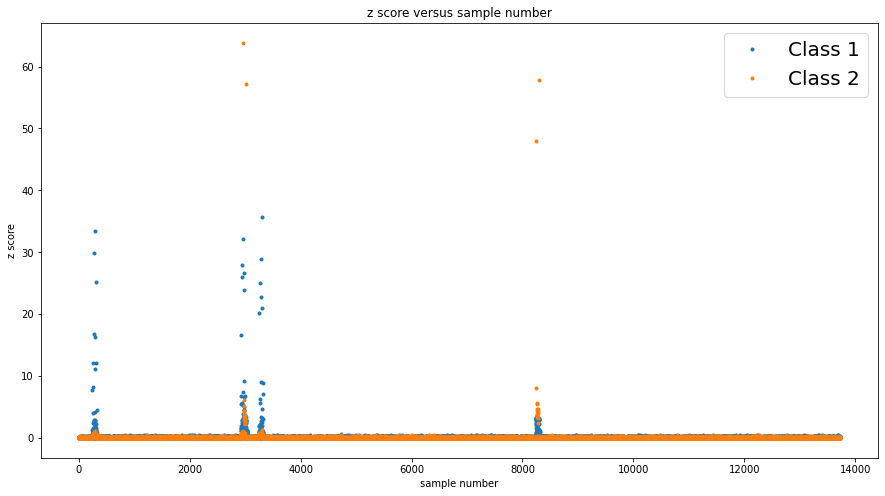

In [443]:
plt.figure(figsize=(15,8))
plt.plot(zscore.data.cpu().numpy()[0][0],".",label="Class 1")
plt.plot(zscore.data.cpu().numpy()[0][1],".",label="Class 2")
plt.title("z score versus sample number")
plt.ylabel("z score")
plt.xlabel("sample number")
plt.legend(loc=1,fontsize=20)
plt.show()

### Run model (on GPU)

In [435]:
%%timeit
zscore = infer(batch, test_model)

15.4 ms ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Compare to CPU

In [437]:
test_model = test_model.to('cpu')
batch = batch.to('cpu')

In [438]:
%%timeit
zscore = infer(batch, test_model)

124 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
